In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd
import datetime

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# statistical modelling
from scipy import stats
import statsmodels.formula.api as smf

In [5]:
case_count_details = pd.read_csv('Datasets/covid-19-india-data/complete.csv')

# preview case count data
print(case_count_details.info())

case_count_details.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 10 columns):
Date                         3370 non-null object
Name of State / UT           3370 non-null object
Latitude                     3370 non-null float64
Longitude                    3370 non-null float64
Total Confirmed cases        3370 non-null int64
Death                        3370 non-null int64
Cured/Discharged/Migrated    3370 non-null int64
New cases                    3370 non-null int64
New deaths                   3370 non-null int64
New recovered                3370 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 263.4+ KB
None


,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
2839,2020-06-10,Tamil Nadu,11.1271,78.6569,34914,307,18325,1685,21,798
402,2020-03-27,Karnataka,15.3173,75.7139,55,2,3,0,0,0
2083,2020-05-19,Uttarakhand,30.0668,79.0193,93,1,52,1,0,0
3248,2020-06-22,Madhya Pradesh,22.9734,78.6569,11903,515,9015,179,14,135
3321,2020-06-24,Meghalaya,25.4670,91.3662,46,1,37,2,0,0


In [6]:
case_count_details=case_count_details.rename(columns = {'Name of State / UT':'region', 'Total Confirmed cases': 'confirmed', 'Cured/Discharged/Migrated': 'recovered', 'Death': 'death', 'Date':'date', 'Latitude':'latitude', 'Longitude':'longitude'})

In [7]:
case_count_details['region'].value_counts()

Kerala                                      148
Delhi                                       116
Haryana                                     114
Rajasthan                                   114
Uttar Pradesh                               114
Tamil Nadu                                  111
Maharashtra                                 109
Punjab                                      109
Karnataka                                   109
Andhra Pradesh                              106
Uttarakhand                                 103
Odisha                                      102
Telengana                                   102
Puducherry                                  100
Chhattisgarh                                 99
West Bengal                                  98
Gujarat                                      98
Ladakh                                       97
Himachal Pradesh                             97
Jammu and Kashmir                            97
Madhya Pradesh                          

In [8]:
remove = ['Union Territory of Ladakh', 'Union Territory of Jammu and Kashmir', 'Union Territory of Chandigarh']
case_count_details = case_count_details[~case_count_details.region.str.contains('|'.join(remove))]
case_count_details['region'] = case_count_details['region'].replace('Telangana', 'Telengana')

In [9]:
overall_first_date = datetime.datetime.strptime(min(case_count_details['date']),  '%Y-%m-%d')
overall_last_date = datetime.datetime.strptime(max(case_count_details['date']),  '%Y-%m-%d')
one_day = datetime.timedelta(1)
regions = sorted(case_count_details['region'].unique())
# Storing the latitudes and longitudes in a dictionary - just in case we use them later
region_latitude = {}
region_longitude = {}
to_be_appended = []
for region in regions:
    region_latitude[region] = case_count_details[case_count_details['region']==region].iloc[0]['latitude']
    region_longitude[region] = case_count_details[case_count_details['region']==region].iloc[0]['longitude']
    dates = list(case_count_details[case_count_details['region']==region]['date'])
    region_last_date = datetime.datetime.strptime(dates[-1], '%Y-%m-%d')
    while region_last_date!=overall_first_date:
        prev_record = case_count_details[(case_count_details['region']==region) & (case_count_details['date']==str(region_last_date)[:10])].copy(deep=True)
        if (len(prev_record)==0):
            prev_record = to_be_appended[-1].copy(deep=True)
        region_last_date-=one_day
        if str(region_last_date)[:10] not in dates:
            prev_record.loc[prev_record.index[0], 'date'] = str(region_last_date)[:10]
            to_be_appended.append(prev_record)
case_count_details = pd.concat(to_be_appended+[case_count_details])

In [10]:
region_wise_confirmed = pd.DataFrame(columns=case_count_details['date'].unique(), index = regions)
for i in case_count_details.values:
    region_wise_confirmed.loc[i[1], i[0]] = i[4] # i[1] - region, i[0] - date, i[4] - confirmed
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1).T
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1)
region_wise_confirmed

,Andaman and Nicobar Islands,Andhra Pradesh,Arunachal Pradesh,Assam,Bihar,Chandigarh,Chhattisgarh,Dadra and Nagar Haveli and Daman and Diu,Delhi,Goa,...,Puducherry,Punjab,Rajasthan,Sikkim,Tamil Nadu,Telengana,Tripura,Uttar Pradesh,Uttarakhand,West Bengal
2020-01-30,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-01-31,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-01,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-02,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
2020-02-03,1,1,1,1,2,1,1,1,1,3,...,1,1,1,1,1,1,1,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-21,47,8452,135,4904,7533,404,2041,68,56746,754,...,286,3952,14536,70,56845,7072,1186,16594,2301,13531
2020-06-22,48,8999,135,5388,7612,406,2275,88,59746,754,...,366,4074,14930,78,59377,7802,1221,17731,2344,13945
2020-06-23,48,9372,139,5586,7825,411,2303,91,62655,864,...,383,4235,15232,78,62087,8674,1237,18322,2402,14358
2020-06-24,50,10002,148,5831,8153,418,2362,120,66602,909,...,402,4397,15627,79,64603,9553,1259,18893,2535,14728


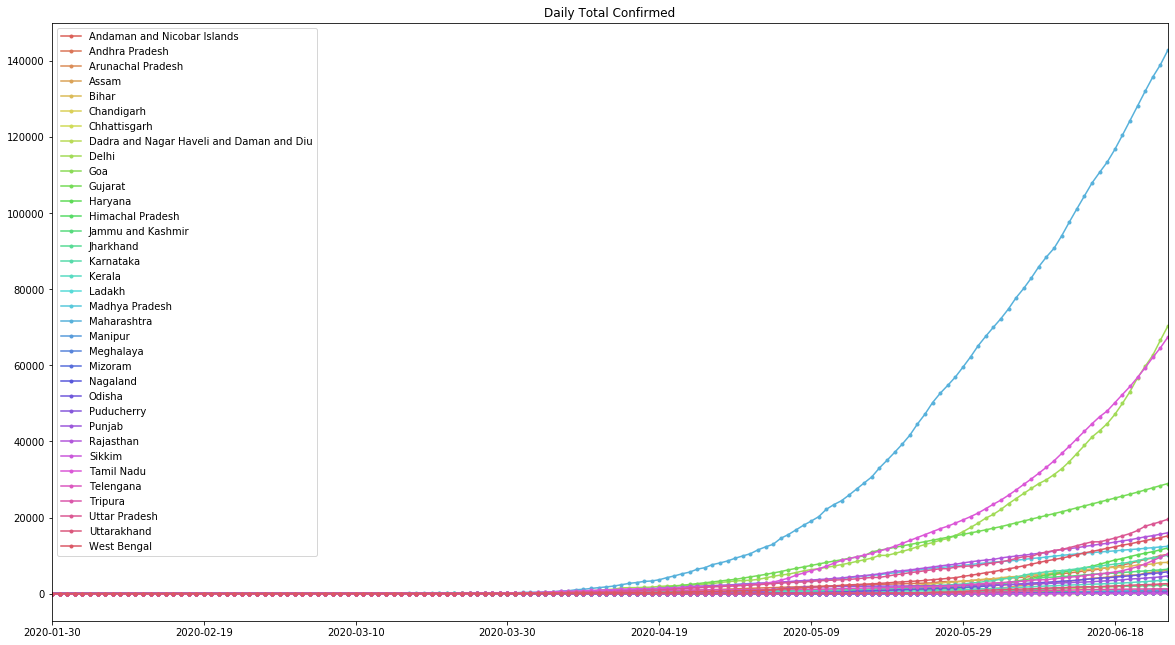

In [11]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_confirmed.iloc[:,:].plot(marker='.',figsize=(20,11)).set_title('Daily Total Confirmed');
plt.legend(loc = 'upper left');

In [12]:
region_wise_confirmed = region_wise_confirmed.stack().reset_index(name='confirmed')
region_wise_confirmed.columns = ['date', 'region','confirmed']
region_wise_confirmed['date'] = pd.to_datetime(region_wise_confirmed['date'] ,errors ='coerce')

num_pred = 5
for _ in range(num_pred):
    for region in regions:
        region_wise_confirmed=region_wise_confirmed.append({'date':overall_last_date+one_day, 'region':region, 'confirmed':1}, ignore_index=True)
    overall_last_date+=one_day

region_wise_confirmed = region_wise_confirmed.sort_values(['region', 'date'])
region_wise_confirmed = region_wise_confirmed.reset_index(drop=True)
region_wise_confirmed

,date,region,confirmed
0,2020-01-30,Andaman and Nicobar Islands,1
1,2020-01-31,Andaman and Nicobar Islands,1
2,2020-02-01,Andaman and Nicobar Islands,1
3,2020-02-02,Andaman and Nicobar Islands,1
4,2020-02-03,Andaman and Nicobar Islands,1
...,...,...,...
5350,2020-06-26,West Bengal,1
5351,2020-06-27,West Bengal,1
5352,2020-06-28,West Bengal,1
5353,2020-06-29,West Bengal,1


In [13]:
# Kalman Filters in detail: http://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman filter.pdf

region_wise_confirmed['kalman_prediction'] = 0
phi = np.eye(2)
phi[0][1]=0.45
Q = np.array([[0.00010252, 0.00045563], [0.00045563, 0.002025  ]]) # Found the params in https://github.com/Rank23/COVID19/blob/master/COVID19%20Prediction.ipynb
H = np.array([[1., 0.]])
R = 0.01
for pred in range(num_pred):
    for region in regions:
        inp = list(region_wise_confirmed[region_wise_confirmed['region']==region]['confirmed'].values)
        inp = inp[:len(inp)+1-num_pred+pred]
        kalman_prediction = []
        inp=inp[:len(inp)-pred-1] +list(region_wise_confirmed[region_wise_confirmed['region']==region]['kalman_prediction'].values)[len(inp)-1-pred:len(inp)-1]+[1]
        X = np.array([0,0])[:, np.newaxis]
        P = np.eye(2)
        for z in inp:
            P_prime = np.matmul(phi, np.matmul(P, phi.T))+Q
            X_prime = np.matmul(phi, X)
            K = np.matmul(P_prime, np.matmul(H.T, 1/(np.matmul(H, np.matmul(P_prime, H.T))+R)))
            X = X_prime + K * (z - np.matmul(H, X_prime))
            P = P_prime - np.matmul(K*H, P_prime)
            kalman_prediction.append(np.round(X_prime[0]))
        region_wise_confirmed.loc[region_wise_confirmed['region']==region,'kalman_prediction']=kalman_prediction+[1]*(num_pred-pred-1)

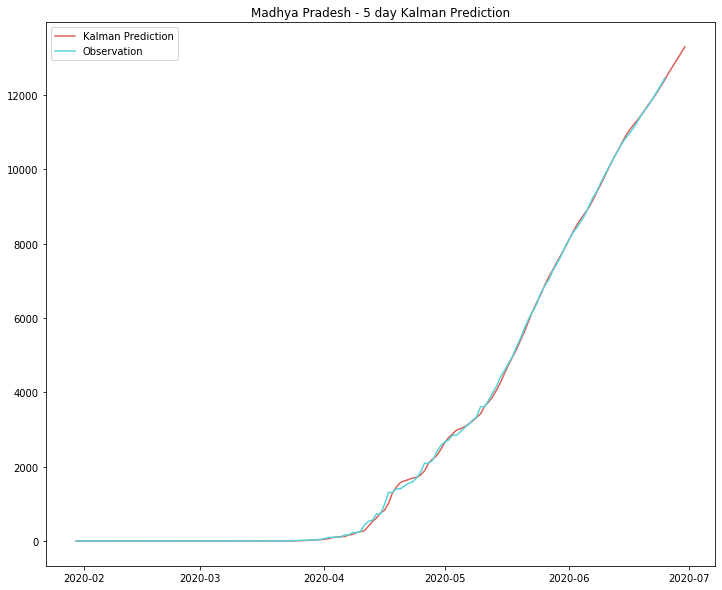

In [14]:
# Pick a region of your choice
sns.set_palette(sns.color_palette("hls", 2))
region = "Madhya Pradesh"
plt.figure(figsize=(12,10))
region_data = region_wise_confirmed[region_wise_confirmed['region']==region]
plt.plot(region_data['date'], region_data['kalman_prediction']);
plt.plot(region_data['date'][:-num_pred], region_data['confirmed'][:-num_pred]);
plt.legend(['Kalman Prediction', 'Observation']);
plt.title('%s - %d day Kalman Prediction' % (region, num_pred));

In [15]:
region_details = pd.read_csv('Datasets/indian-states-and-union-territories/region_details.csv')
region_wise_confirmed = pd.merge(region_wise_confirmed, region_details,how='left' ,on=['region'])
for i in range(len(region_wise_confirmed)):
    region_wise_confirmed.iloc[i,0] = int((region_wise_confirmed.iloc[i,0]-overall_first_date).days)
region_wise_confirmed=region_wise_confirmed.rename(columns={'date': 'num_days_from_start'})
region_mapping = {region:index for index,region in enumerate(regions)}
region_wise_confirmed['region'] = region_wise_confirmed['region'].map(region_mapping) 
region_wise_confirmed

,num_days_from_start,region,confirmed,kalman_prediction,population,rural_population,urban_population,area,density,gender_ratio,literacy_rate,poverty,hdi
0,0,0,1,0,380581.0,237093.0,143488.0,8249.0,46.0,876.0,86.27,1.00,0.739
1,1,0,1,1,380581.0,237093.0,143488.0,8249.0,46.0,876.0,86.27,1.00,0.739
2,2,0,1,1,380581.0,237093.0,143488.0,8249.0,46.0,876.0,86.27,1.00,0.739
3,3,0,1,1,380581.0,237093.0,143488.0,8249.0,46.0,876.0,86.27,1.00,0.739
4,4,0,1,1,380581.0,237093.0,143488.0,8249.0,46.0,876.0,86.27,1.00,0.739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5350,148,34,1,15568,91276115.0,62183113.0,29093002.0,88752.0,1029.0,953.0,77.08,13.98,0.641
5351,149,34,1,15976,91276115.0,62183113.0,29093002.0,88752.0,1029.0,953.0,77.08,13.98,0.641
5352,150,34,1,16383,91276115.0,62183113.0,29093002.0,88752.0,1029.0,953.0,77.08,13.98,0.641
5353,151,34,1,16791,91276115.0,62183113.0,29093002.0,88752.0,1029.0,953.0,77.08,13.98,0.641


In [16]:
delta = (overall_last_date-overall_first_date).days
test = region_wise_confirmed[region_wise_confirmed['num_days_from_start']>delta-num_pred].drop(['confirmed'], axis=1).apply(pd.to_numeric)
train = region_wise_confirmed[region_wise_confirmed['num_days_from_start']<=delta-num_pred].apply(pd.to_numeric)
print ('Train size: %d' %len(train))
print ('Test size: %d' %len(test))

Train size: 5180
Test size: 175


In [17]:
smf.ols(formula='confirmed ~ num_days_from_start + region + kalman_prediction + population + rural_population + urban_population + area + density + gender_ratio + literacy_rate + poverty + hdi', data=train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              confirmed   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.419e+06
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:13:23   Log-Likelihood:                -30035.
No. Observations:                5032   AIC:                         6.009e+04
Df Residuals:                    5020   BIC:                         6.017e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             167.1246     53.839      3.104      0.002      61.577     272.672
num_days_from_start     0.1968      0.033      5.937      0.000       0.132       0.262
region                 -0.1211      0.157     -0.773      0.439      -0.428       0.186
kalman_prediction       1.0052      0.000   5910.298      0.000       1.005       1.006
population           2.142e-06   4.94e-07      4.339      0.000    1.17e-06    3.11e-06
rural_population    -2.612e-06   5.52e-07     -4.732      0.000   -3.69e-06   -1.53e-06
urban_population    -3.642e-07   4.26e-07     -0.855      0.392    -1.2e-06    4.71e-07
area                -6.948e-05   2.47e-05     -2.808      0.005      -0.000    -2.1e-05
density                 0.0045      0.001      6.259      0.000       0.003       0.006
gender_ratio           -0.0164      0.033     -0.493      0.622      -0.082       0.049
literacy_rate           0.1245      0.301      0.413      0.680      -0.466       0.715
poverty                -0.5633      0.184     -3.068      0.002      -0.923      -0.203
hdi                  -235.6048     57.337     -4.109      0.000    -348.010    -123.199
==============================================================================
Omnibus:                     3502.063   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           810754.679
Skew:                           2.274   Prob(JB):                         0.00
Kurtosis:                      65.018   Cond. No.                     8.61e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.36e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [18]:
lm = smf.ols(formula='confirmed ~ kalman_prediction + rural_population + urban_population + density', data=train).fit()
region_wise_confirmed.iloc[region_wise_confirmed[region_wise_confirmed['num_days_from_start']>delta-num_pred].index, 2] = np.round(lm.predict(test))

In [19]:
for i in range(len(region_wise_confirmed)):
    region_wise_confirmed.iloc[i,0] = overall_first_date+one_day*int(region_wise_confirmed.iloc[i,0])
region_wise_confirmed=region_wise_confirmed.rename(columns={'num_days_from_start': 'date'})
inverse_region_mapping = {region_mapping[i]:i for i in region_mapping}
region_wise_confirmed['region'] = region_wise_confirmed['region'].map(inverse_region_mapping)

In [20]:
temp = region_wise_confirmed.copy(deep=True)

region_wise_confirmed = pd.DataFrame(columns=temp['date'].unique(), index = regions)
region_wise_kalman_pred = pd.DataFrame(columns=temp['date'].unique(), index = regions)
for i in temp.values:
    region_wise_confirmed.loc[i[1], i[0]] = i[2] # i[1] - region, i[0] - date, i[2] - confirmed
    region_wise_kalman_pred.loc[i[1], i[0]] = i[3] # i[1] - region, i[0] - date, i[3] - kalman prediction
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1).T
region_wise_confirmed = region_wise_confirmed.reindex(sorted(region_wise_confirmed.columns), axis=1)
region_wise_kalman_pred = region_wise_kalman_pred.reindex(sorted(region_wise_kalman_pred.columns), axis=1).T
region_wise_kalman_pred = region_wise_kalman_pred.reindex(sorted(region_wise_kalman_pred.columns), axis=1)

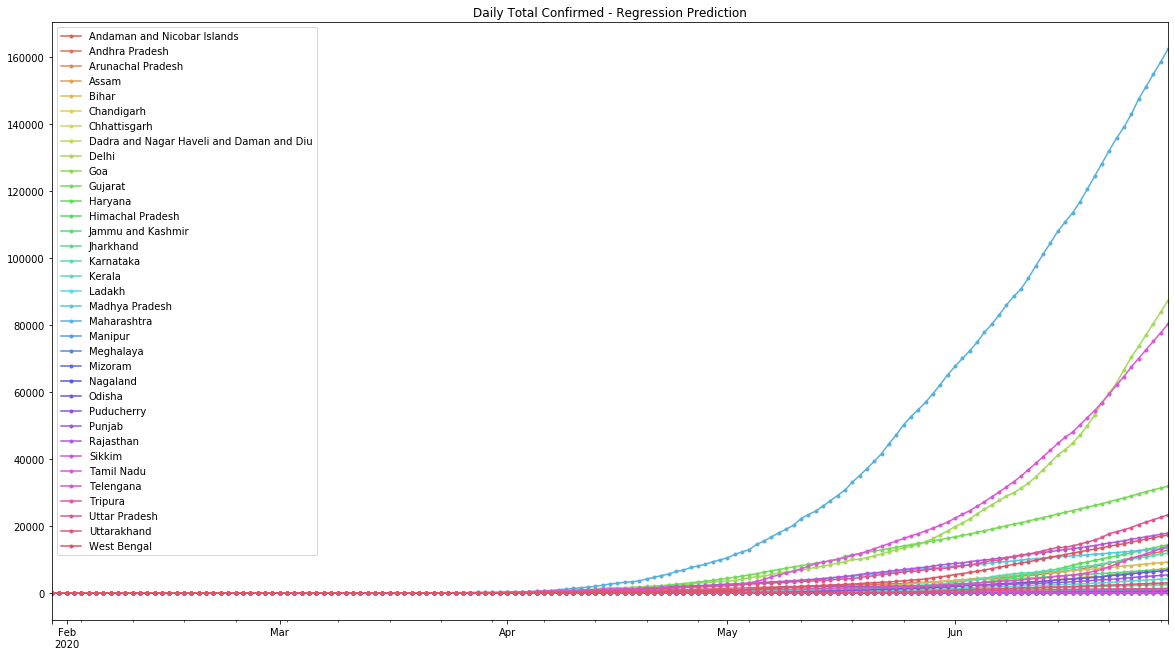

In [21]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_confirmed.iloc[:,:].plot(marker='.',figsize=(20,11)).set_title('Daily Total Confirmed - Regression Prediction');
plt.legend(loc = 'upper left');

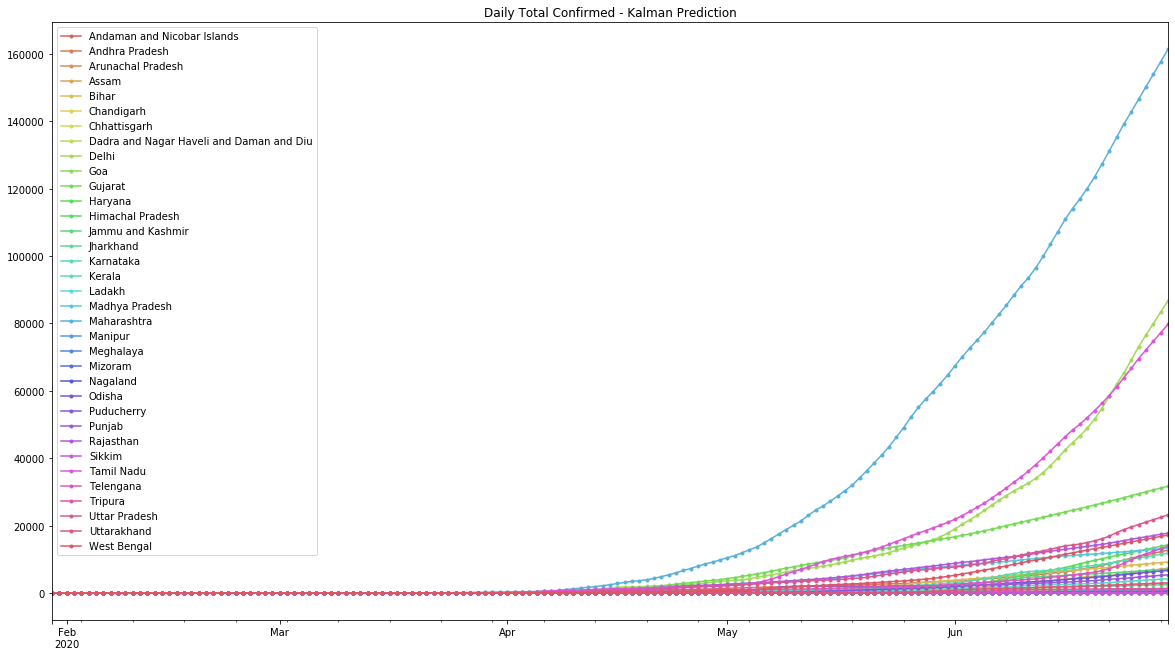

In [22]:
sns.set_palette(sns.color_palette('hls', len(regions)))
region_wise_kalman_pred.iloc[:,:].plot(marker='.',figsize=(20,11)).set_title('Daily Total Confirmed - Kalman Prediction');
plt.legend(loc = 'upper left');